## Estimate effect of guides from on-target knock-down

In [1]:
# import rpy2.robjects.pandas2ri
# import rpy2.robjects.numpy2ri

In [29]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import yaml
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from copy import deepcopy

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection
from preprocess import _convert_oak_path

In [49]:
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
sgrna_library_metadata_clean = pd.read_csv('../5_sgRNA_annotation/results/sgrna_df_final.csv', index_col=0).set_index('sgRNA')
sgrna_library_metadata_clean

chromosome        pos         seq_last19bp strand    PAM  \
sgRNA                                                                
ARMC5-1        chr16   31459566  TGCCTCGCGCAGCTCGCGG      +   True   
DDB1-1         chr11   61333047  GAGTTCGCTGCGCGCTGTT      -   True   
FNDC10-1        chr1    1600078  GCCCGCTCCCCGCGATCCC      +   True   
RORC-1          chr1  151831746  CTGTGGGGCCCTGTCCATG      +   True   
SLC35F6-1       chr2   26764356  AACAGCTGGTACTTGGTCC      -   True   
...              ...        ...                  ...    ...    ...   
TYW1B-1         chr7   72744713  GCGTCGTGCAGATACTAGT      -   True   
NBPF14-1        chr1  120451417  AATATTTATCAAACAGAGG      +   True   
MUC12-2         chr7  100969567  TCTTGGTCCCTCCTGACGA      +  False   
SRGAP2-2        chr1  206463364  CACAGGTCCCGAGCCAACG      +   True   
NBPF11-2        chr1  148152266  GCCTGCAGTCCTAAACGCT      -   True   

                                                        note   flag  \
sgRNA                                                                 
ARMC5-1             unique alignment, aligned to target gene  False   
DDB1-1              unique alignment, aligned to target gene  False   
FNDC10-1            unique alignment, aligned to target gene  False   
RORC-1              unique alignment, aligned to target gene  False   
SLC35F6-1           unique alignment, aligned to target gene  False   
...                                                      ...    ...   
TYW1B-1    hg17 alignment, AtoG at pos6, aligned to a cds...   True   
NBPF14-1   hg17 alignment, AtoG at pos19, multi alignment...   True   
MUC12-2    hg17 alignment, TtoC at pos17, aligned to targ...   True   
SRGAP2-2   hg17 alignment, AtoG at pos11, within target g...   True   
NBPF11-2   hg17 alignment, GtoT at pos19, aligned to targ...   True   

                            seq target_gene_name_from_sgRNA  \
sgRNA                                                         
ARMC5-1    CTGCCTCGCGCAGCTCGCGG                       ARMC5   
DDB1-1     GGAGTTCGCTGCGCGCTGTT                        DDB1   
FNDC10-1   TGCCCGCTCCCCGCGATCCC                      FNDC10   
RORC-1     TCTGTGGGGCCCTGTCCATG                        RORC   
SLC35F6-1  GAACAGCTGGTACTTGGTCC                     SLC35F6   
...                         ...                         ...   
TYW1B-1    GGCGTCGTGCAGATACTAGT                       TYW1B   
NBPF14-1   GAATATTTATCAAACAGAGG                      NBPF14   
MUC12-2    GTCTTGGTCCCTCCTGACGA                       MUC12   
SRGAP2-2   GCACAGGTCCCGAGCCAACG                      SRGAP2   
NBPF11-2   GGCCTGCAGTCCTAAACGCT                      NBPF11   

          designed_target_gene_id  ...  \
sgRNA                              ...   
ARMC5-1           ENSG00000140691  ...   
DDB1-1            ENSG00000167986  ...   
FNDC10-1          ENSG00000228594  ...   
RORC-1            ENSG00000143365  ...   
SLC35F6-1         ENSG00000213699  ...   
...                           ...  ...   
TYW1B-1           ENSG00000277149  ...   
NBPF14-1          ENSG00000270629  ...   
MUC12-2           ENSG00000205277  ...   
SRGAP2-2          ENSG00000266028  ...   
NBPF11-2          ENSG00000263956  ...   

                                     nearby_gene_within_30kb  \
sgRNA                                                          
ARMC5-1    ['ENSG00000176723', 'ENSG00000140691', 'ENSG00...   
DDB1-1     ['ENSG00000167986', 'ENSG00000149476', 'ENSG00...   
FNDC10-1   ['ENSG00000160075', 'ENSG00000228594', 'ENSG00...   
RORC-1     ['ENSG00000213171', 'ENSG00000143365', 'ENSG00...   
SLC35F6-1             ['ENSG00000213699', 'ENSG00000115163']   
...                                                      ...   
TYW1B-1                                                   []   
NBPF14-1                                                  []   
MUC12-2               ['ENSG00000169894', 'ENSG00000205277']   
SRGAP2-2              ['ENSG00000266028', 'ENSG00000263528']   
NBPF11-2                                

In [10]:


config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)
# Read config for both experiments
experiment_names = ['CD4iR1_Psomagen', 'CD4iR2_Psomagen']
sample_info_list = []

for experiment_name in experiment_names:
    # Get config for this experiment
    config_exp = config[experiment_name]
    datadir = _convert_oak_path(config_exp['datadir'])
    
    # Find all postQC h5ad files in tmp directory
    tmp_dir = os.path.join(datadir, 'tmp')
    h5ad_files = [f for f in os.listdir(tmp_dir) if f.endswith('.postQC.h5ad')]
    
    for h5ad_file in h5ad_files:
        # Read h5ad file to get culture condition
        culture_condition = h5ad_file.split('_')[3]
        
        # Get sample ID from filename
        sample_id = h5ad_file.replace('.scRNA.postQC.h5ad', '')
        
        sample_info_list.append({
            'sample_id': sample_id,
            'culture_condition': culture_condition,
            'datadir': datadir,
            'experiment': experiment_name
        })

# Combine all sample info into one dataframe
sample_info_df = pd.DataFrame(sample_info_list)

len(sample_info_df[sample_info_df['culture_condition'] == 'Rest'])

94

In [11]:
def get_sample_stats(datadir, sample_id):
    """
    Calculate guide and NTC statistics for a single sample.
    
    Args:
        datadir (str): Path to data directory
        sample_id (str): Sample ID
        
    Returns:
        tuple: (sample_guide_sums, sample_guide_sums_sq, sample_n_cells, 
                sample_ntc_sums, sample_ntc_sums_sq)
    """
    f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    adata = anndata.experimental.read_lazy(f)
    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()

    targeting_mask = adata.obs['guide_type'] == 'targeting'
    cell2guide = pd.get_dummies(adata[targeting_mask].obs['guide_id']).astype(int)
    target_gene_values = adata[targeting_mask].obs['target_lognorm_expr'].values

    # Calculate statistics for this sample
    sample_guide_sums = pd.DataFrame(
        target_gene_values.reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_guide_sums_sq = pd.DataFrame(
        (target_gene_values ** 2).reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_n_cells = pd.DataFrame(
        cell2guide.sum(axis=0),
        index=cell2guide.columns,
        columns=[sample_id]
    )

    sample_ntc_sums = pd.DataFrame(
        adata.var['sum_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums_sq = pd.DataFrame(
        adata.var['sum_sq_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums.loc['n_ntc_cells'] = adata.uns['n_ntc']
    
    return (sample_guide_sums, sample_guide_sums_sq, sample_n_cells,
            sample_ntc_sums, sample_ntc_sums_sq)

In [12]:
results_dir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_Psomagen'

# Initialize empty dataframes to store results for all samples
guide_sums_df = pd.DataFrame()
guide_sums_sq_df = pd.DataFrame()
n_cells_guide_df = pd.DataFrame()
ntc_sums_df = pd.DataFrame()  
ntc_sums_sq_df = pd.DataFrame()  

# Process each sample
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    for it in tqdm(sample_info_df[sample_info_df.culture_condition == c].iterrows(), desc=f"Processing {c} samples"):
        i,x = it
        sample_guide_sums, sample_guide_sums_sq, sample_n_cells, sample_ntc_sums, sample_ntc_sums_sq = get_sample_stats(x['datadir'], x['sample_id'])
        # Concatenate with existing results
        guide_sums_df = pd.concat([guide_sums_df, sample_guide_sums], axis=1)
        guide_sums_sq_df = pd.concat([guide_sums_sq_df, sample_guide_sums_sq], axis=1)
        n_cells_guide_df = pd.concat([n_cells_guide_df, sample_n_cells], axis=1)
        ntc_sums_df = pd.concat([ntc_sums_df, sample_ntc_sums], axis=1)  
        ntc_sums_sq_df = pd.concat([ntc_sums_sq_df, sample_ntc_sums_sq], axis=1)  

    # Gest summary stats for each guide
    total_guide_sums = guide_sums_df.fillna(0).sum(1)
    total_guide_sums_sq = guide_sums_sq_df.fillna(0).sum(1)
    total_guide_n = n_cells_guide_df.fillna(0).sum(1)
    guide_mean_expr = total_guide_sums / total_guide_n
    guide_std_expr = np.sqrt((total_guide_sums_sq - total_guide_sums**2 / total_guide_n) / (total_guide_n - 1))
    guide_std_expr = guide_std_expr.fillna(100) # cases with one cell with guide

    # Get summary stats for expression in NTCs
    total_ntc_sums = ntc_sums_df.drop('n_ntc_cells').fillna(0).sum(1) 
    total_ntc_sums_sq = ntc_sums_sq_df.fillna(0).sum(1) 
    total_ntc_n = ntc_sums_df.loc['n_ntc_cells'].sum()
    ntc_mean_expr = total_ntc_sums / total_ntc_n
    ntc_std_expr = np.sqrt((total_ntc_sums_sq - total_ntc_sums**2 / total_ntc_n) / (total_ntc_n - 1))
    ntc_std_expr = ntc_std_expr.fillna(100) # cases with one cell with guide

    perturbed_genes = sgrna_library_metadata.set_index('sgrna_id').loc[guide_mean_expr.index]['perturbed_gene_id'].values
    ntc_mean_expr = ntc_mean_expr.reindex(perturbed_genes, fill_value=0)
    ntc_mean_expr.index = guide_mean_expr.index
    ntc_std_expr = ntc_std_expr.reindex(perturbed_genes, fill_value=0)
    ntc_std_expr.index = guide_mean_expr.index

    ttest_df = pd.concat([guide_mean_expr, guide_std_expr, total_guide_n, ntc_mean_expr, ntc_std_expr], axis=1, 
                        keys=['guide_mean_expr', 'guide_std_expr', 'guide_n', 'ntc_mean_expr', 'ntc_std_expr'])
    ttest_df['ntc_n'] = total_ntc_n

    # Calculate Welch's t-test for each row
    t_stats = []
    p_values = []
    for _, row in ttest_df.iterrows():
        t_stat, p_value = stats.ttest_ind_from_stats(
            row['guide_mean_expr'], row['guide_std_expr'], row['guide_n'],
            row['ntc_mean_expr'], row['ntc_std_expr'], row['ntc_n'],  # Using std=1.0 for NTCs
            equal_var=False)
        t_stats.append(t_stat)
        p_values.append(p_value)

    ttest_df['t_statistic'] = t_stats
    ttest_df['p_value'] = p_values

    # Compute Benjamini-Hochberg adjusted p-values
    valid_pvals = ttest_df['p_value'].dropna()
    _, adj_pvals, _, _ = multipletests(valid_pvals, method='fdr_bh')
    ttest_df.loc[valid_pvals.index, 'adj_p_value'] = adj_pvals
    ttest_df['signif_knockdown'] = (ttest_df['adj_p_value'] < 0.1) & (ttest_df['t_statistic'] < 0)
    ttest_df['adj_p_value'] = np.where(ttest_df['adj_p_value'] < 1e-16, 1e-16, ttest_df['adj_p_value'])

    # Save ttest_df for condition
    ttest_df.to_csv(f'{results_dir}/{experiment_name}.guide_effect.{c}.csv')

Processing Rest samples: 0it [00:00, ?it/s]

Processing Stim8hr samples: 0it [00:00, ?it/s]

Processing Stim48hr samples: 0it [00:00, ?it/s]

In [13]:
stim_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Stim8hr.csv', index_col=0)
stim48_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Stim48hr.csv', index_col=0)
rest_ttest_df = pd.read_csv(f'{results_dir}/{experiment_name}.guide_effect.Rest.csv', index_col=0)

print(rest_ttest_df.signif_knockdown.value_counts())
print(stim_ttest_df.signif_knockdown.value_counts())
print(stim48_ttest_df.signif_knockdown.value_counts())

stim_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[stim_ttest_df.index]['perturbed_gene_id']
stim48_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[stim48_ttest_df.index]['perturbed_gene_id']
rest_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[rest_ttest_df.index]['perturbed_gene_id']

signif_knockdown
True     19661
False     4826
Name: count, dtype: int64
signif_knockdown
True     20692
False     4164
Name: count, dtype: int64
signif_knockdown
True     21031
False     3941
Name: count, dtype: int64


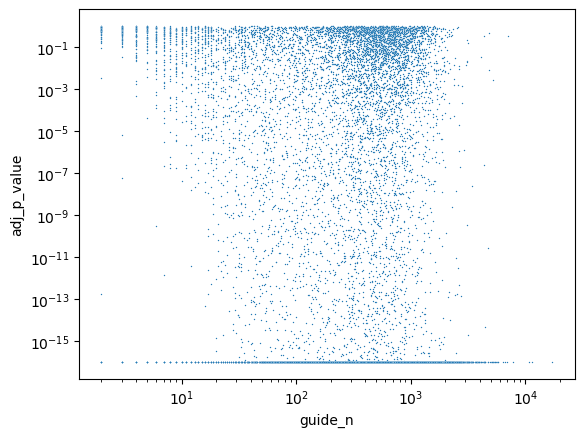

In [14]:
sns.scatterplot(data=stim_ttest_df, x='guide_n', y='adj_p_value', s=1);
plt.xscale('log')
plt.yscale('log')

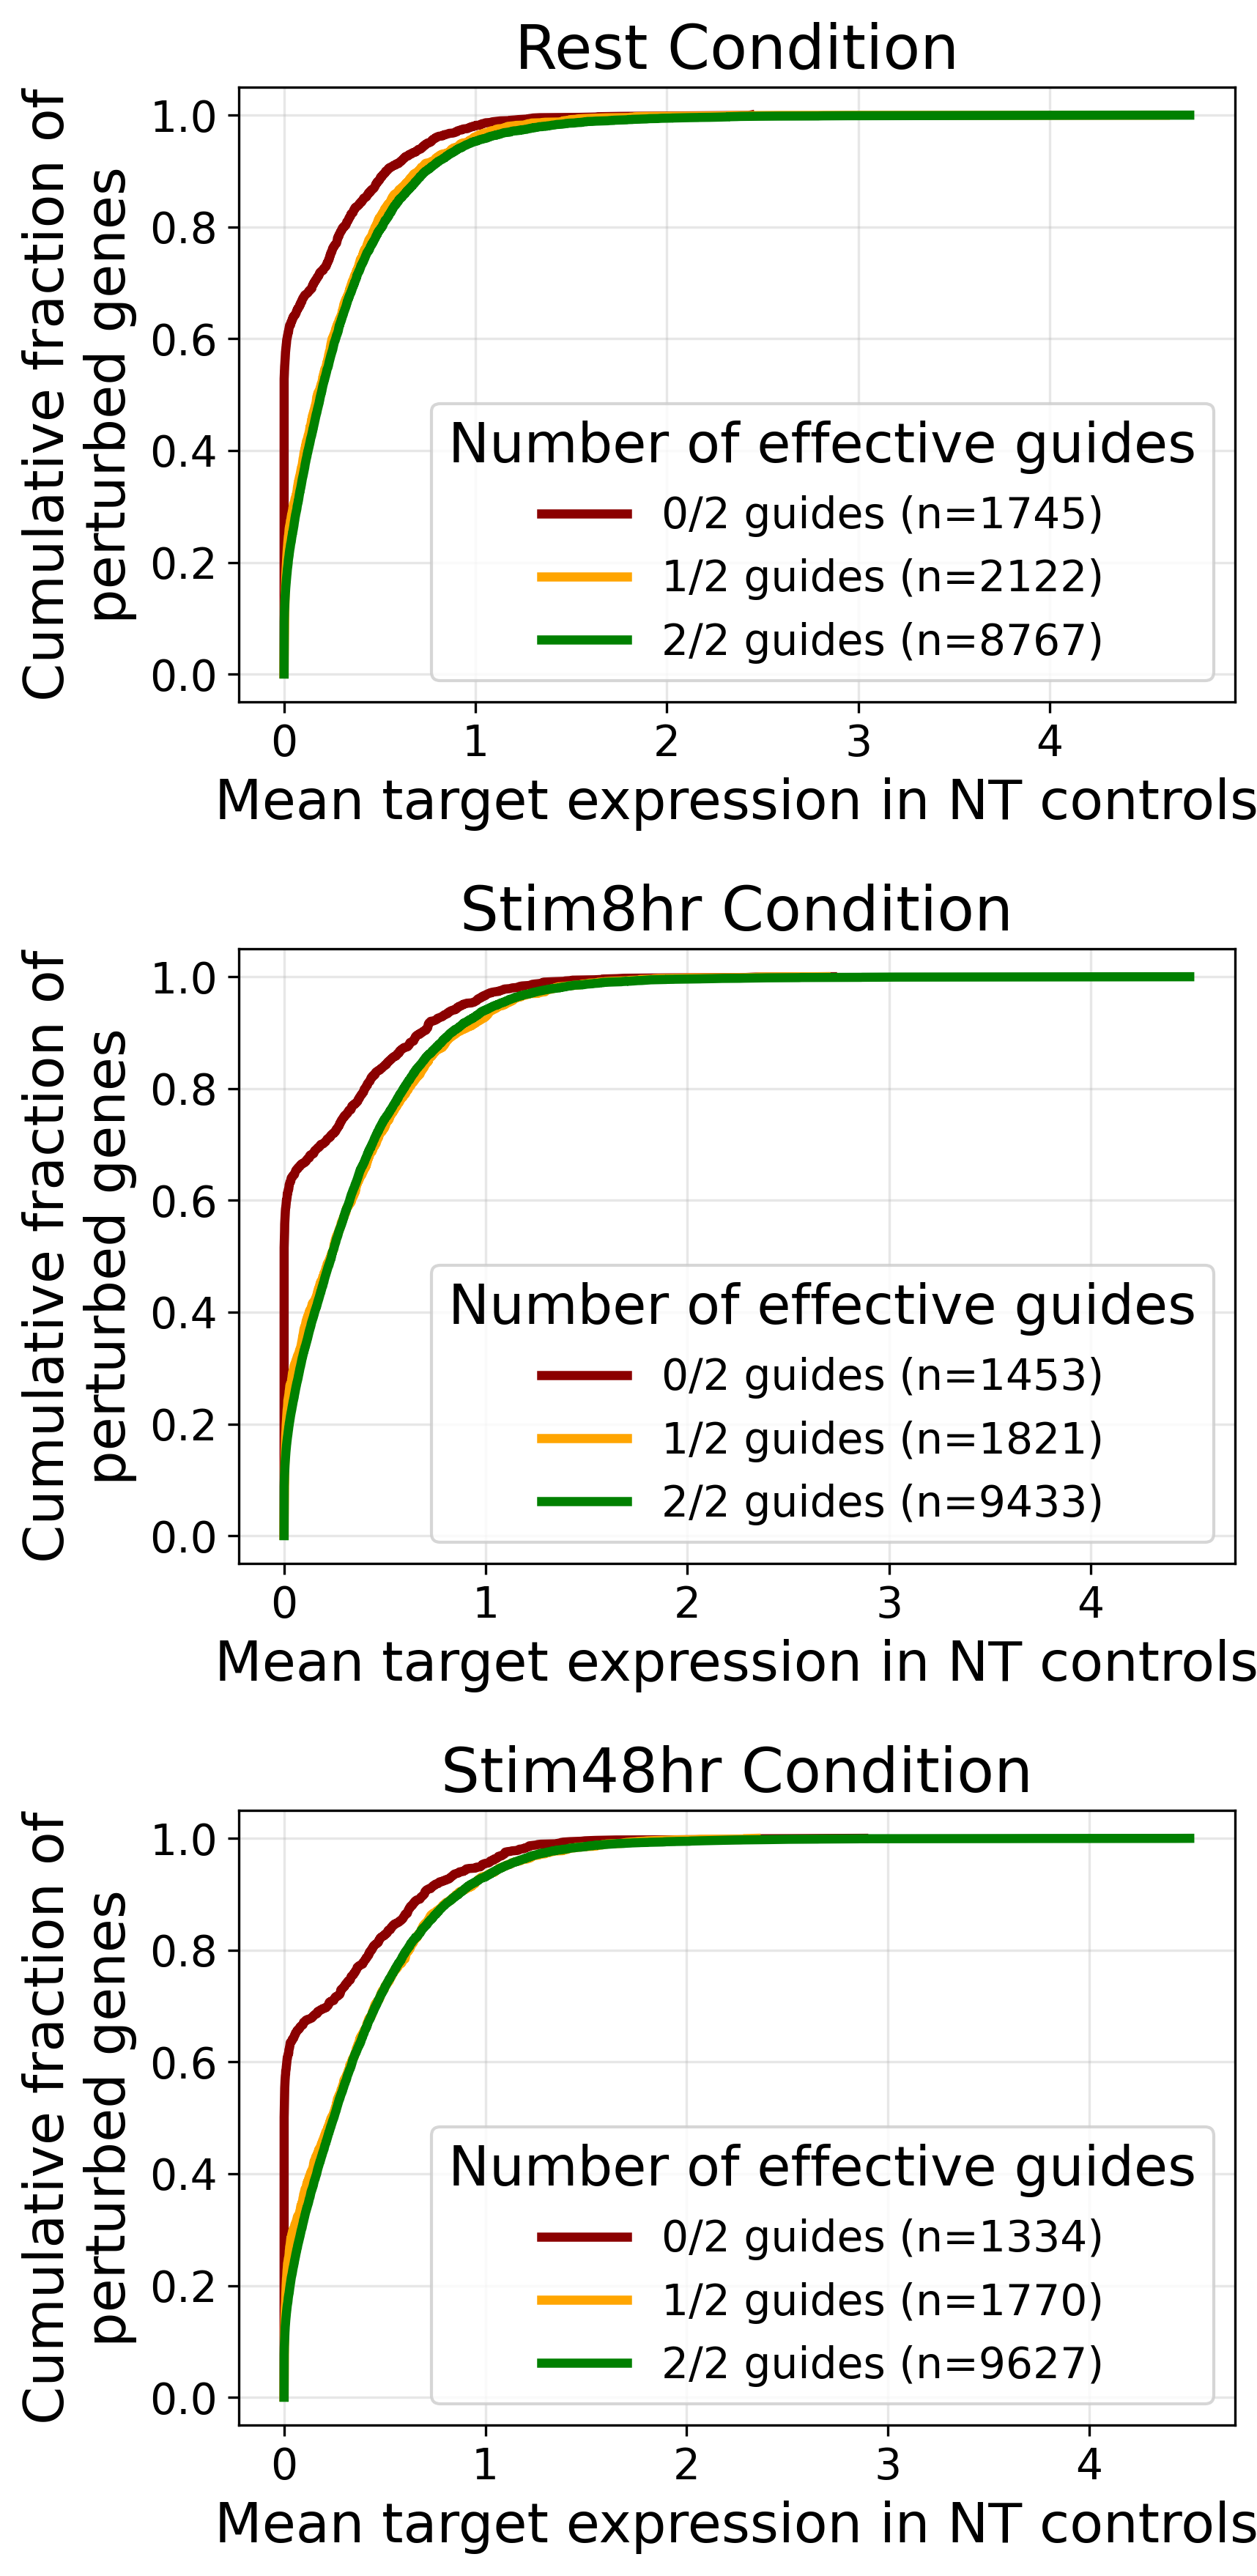

In [32]:
# Create figure with 2 subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))

# Function to create the plot for a given dataframe and axis
def plot_cumulative_dist(df, ax, title):
    pl_df = df.groupby('perturbed_gene_id').agg({
        'ntc_mean_expr': 'mean',
        'signif_knockdown': 'sum'
    })
    pl_df['signif_knockdown'] = np.where(pl_df['signif_knockdown'] > 2, 2, pl_df['signif_knockdown'])

    colors = {2: 'green', 1: 'orange', 0: 'darkred'}
    for knockdown in sorted(pl_df['signif_knockdown'].unique()):
        subset = pl_df[pl_df['signif_knockdown'] == knockdown]
        x = np.sort(subset['ntc_mean_expr'])
        y = np.arange(1, len(x) + 1) / len(x)
        ax.plot(x, y, 
                label=f'{knockdown}/2 guides (n={len(subset)})', 
                linewidth=3,
                color=colors[knockdown])

    ax.set_xlabel('Mean target expression in NT controls', fontsize=18)
    ax.set_ylabel('Cumulative fraction of\nperturbed genes', fontsize=18)
    ax.legend(title='Number of effective guides', fontsize=14, title_fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(title, fontsize=20)

# Plot for both conditions
plot_cumulative_dist(rest_ttest_df, ax1, 'Rest Condition')
plot_cumulative_dist(stim_ttest_df, ax2, 'Stim8hr Condition')
plot_cumulative_dist(stim48_ttest_df, ax3, 'Stim48hr Condition')

plt.tight_layout()

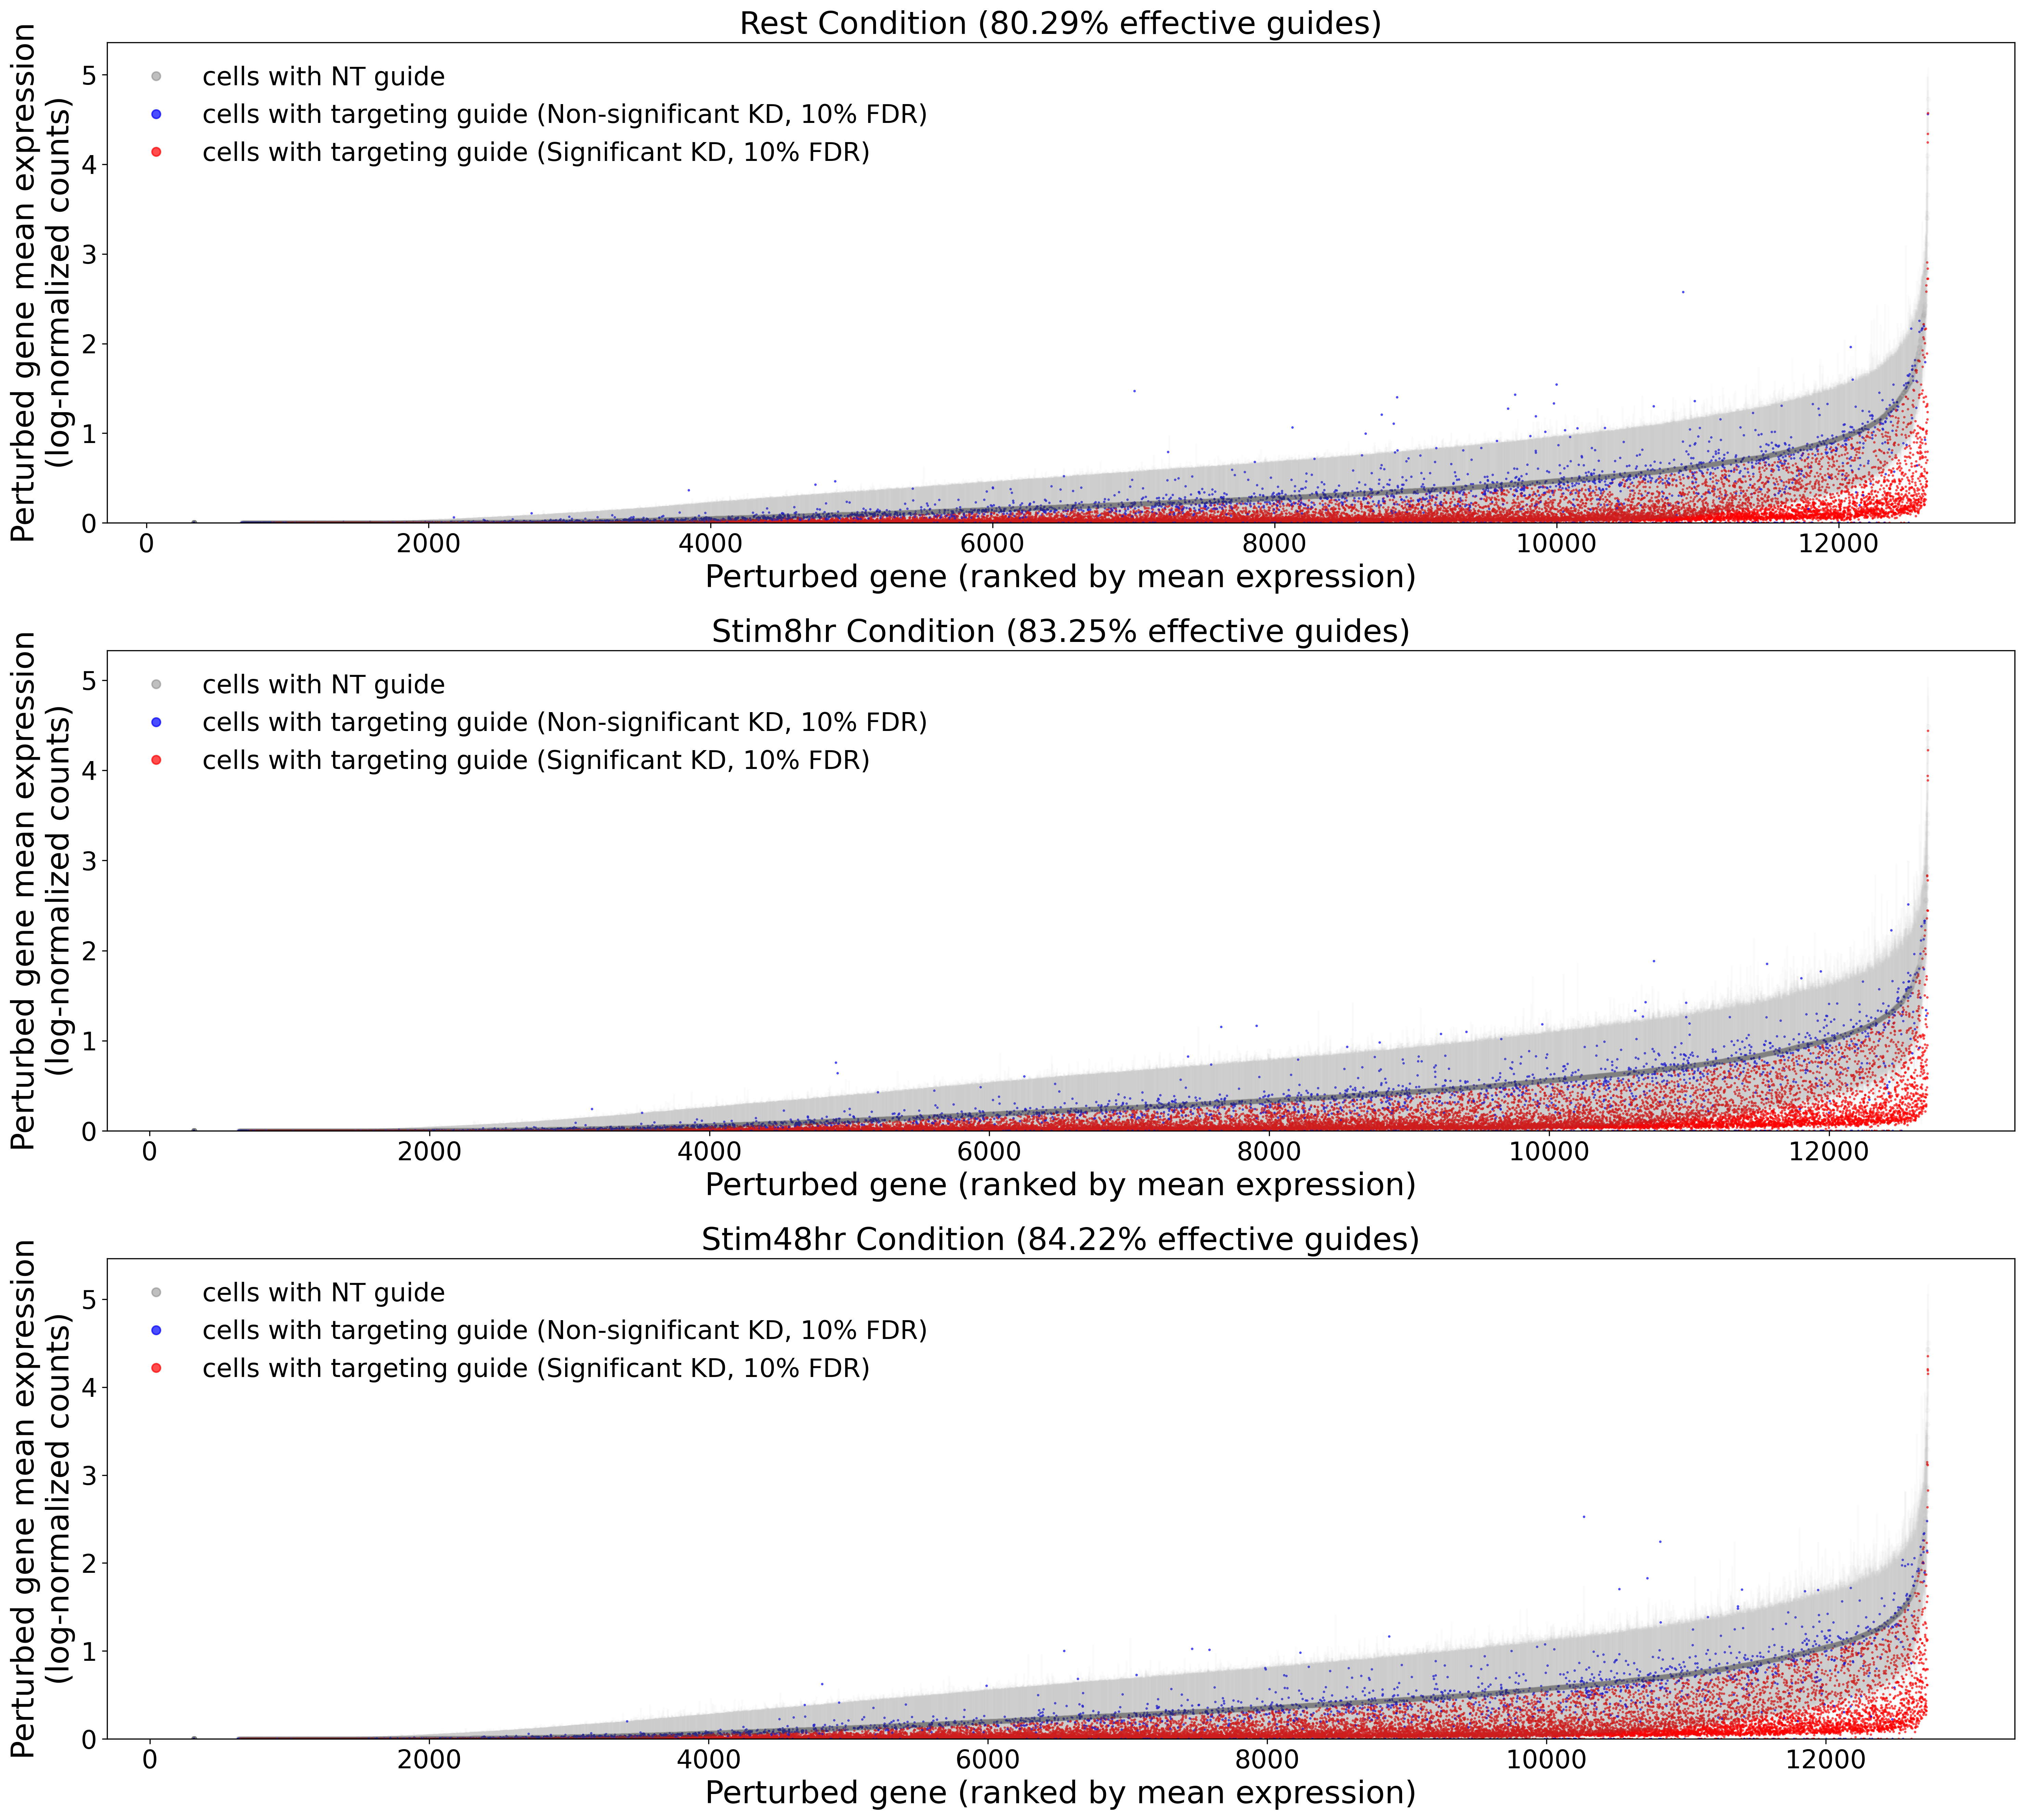

In [33]:

# Function to create the plot for a given dataframe and axis
def plot_expression_rank(df, ax, title):
    # Get unique perturbed genes and their mean NTC expression
    gene_ntc_means = df.groupby('perturbed_gene_id')['ntc_mean_expr'].mean()
    # Rank the perturbed genes by their mean NTC expression
    gene_ranks = gene_ntc_means.rank()
    # Map the gene ranks back to the original dataframe
    df['rank'] = df['perturbed_gene_id'].map(gene_ranks)

    # Plot mean NTC expression with error bars
    ax.errorbar(df['rank'],
                df['ntc_mean_expr'], 
                yerr=df['ntc_std_expr'], 
                fmt='o',
                color='grey',
                markersize=3, 
                alpha=0.01,
                label='NT control cells')

    # Color points based on significance
    sns.scatterplot(
        data=df, 
        y='guide_mean_expr', 
        x='rank',
        s=3, 
        hue='signif_knockdown',
        palette={True: 'red', False: 'blue'},
        hue_order=[True, False],
        legend=False,
        alpha=0.7,
        linewidth=0,
        ax=ax)

    # Add legend
    ax.legend([plt.Line2D([0], [0], marker='o', color='grey', linestyle='', alpha=0.5),
               plt.Line2D([0], [0], marker='o', color='blue', linestyle='', alpha=0.7),
               plt.Line2D([0], [0], marker='o', color='red', linestyle='', alpha=0.7)],
              ['cells with NT guide', 'cells with targeting guide (Non-significant KD, 10% FDR)', 'cells with targeting guide (Significant KD, 10% FDR)'],
              loc='upper left', frameon=False, fontsize=18)
    ax.set_ylim(0)
    ax.set_xlabel('Perturbed gene (ranked by mean expression)', fontsize=22)
    ax.set_ylabel('Perturbed gene mean expression\n(log-normalized counts)', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(title, fontsize=22)


# Create figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,18))

# Plot for all conditions
plot_expression_rank(rest_ttest_df, ax1, f'Rest Condition ({np.round((rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim_ttest_df, ax2, f'Stim8hr Condition ({np.round((stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim48_ttest_df, ax3, f'Stim48hr Condition ({np.round((stim48_ttest_df.signif_knockdown.value_counts()[True]/stim48_ttest_df.shape[0])*100, 2)}% effective guides)')

plt.tight_layout()

In [19]:
st = 'signif_knockdown'
compare_df = pd.concat([stim_ttest_df[st], stim48_ttest_df[st]], axis=1)
compare_df.columns = ['stim', 'stim48']
pd.crosstab(compare_df['stim'], compare_df['stim48'])

stim48  False  True 
stim                
False    3412    752
True      425  20267

<Axes: xlabel='stim', ylabel='stim48'>

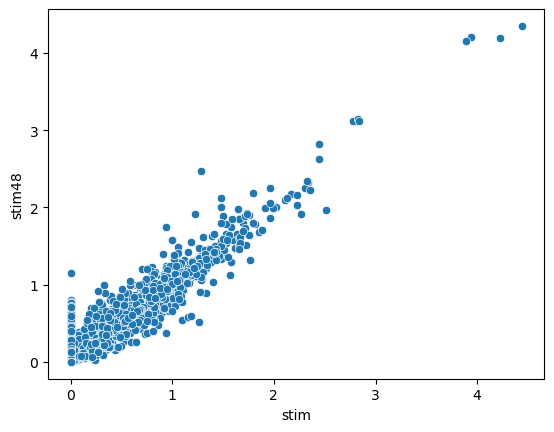

In [27]:
st = 'guide_mean_expr'
compare_df = pd.concat([stim_ttest_df[st], stim48_ttest_df[st]], axis=1)
compare_df.columns = ['stim', 'stim48']
sns.scatterplot(data=compare_df, x='stim', y='stim48')

In [34]:
print(stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])
print(stim48_ttest_df.signif_knockdown.value_counts()[True]/stim48_ttest_df.shape[0])
print(rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])

0.8324750563244288
0.8421832452346628
0.8029158328909217


In [35]:
rest_ttest_df['high_confidence_no_effect_guides'] = (~rest_ttest_df['signif_knockdown']) & (rest_ttest_df.guide_n > 10) & (rest_ttest_df.ntc_mean_expr > 0)
stim_ttest_df['high_confidence_no_effect_guides'] = (~stim_ttest_df['signif_knockdown']) & (stim_ttest_df.guide_n > 10) & (stim_ttest_df.ntc_mean_expr > 0)
stim48_ttest_df['high_confidence_no_effect_guides'] = (~stim48_ttest_df['signif_knockdown']) & (stim48_ttest_df.guide_n > 10) & (stim48_ttest_df.ntc_mean_expr > 0)

In [36]:
def plot_kd(mean_perturbed_gene_expr_df, top_n=100, figsize=(15,6), show_xlabels=True):
    # Group by guide_id instead of perturbed_gene
    guide_means = mean_perturbed_gene_expr_df.copy()

    # Select a subset of guides to plot (to avoid overcrowding)
    pl_df = guide_means.head(top_n)  # Take first 100 guides or adjust as needed
    pl_df
    plt.figure(figsize=figsize)
    # Plot mean NTC expression with error bars
    plt.errorbar(pl_df['guide_id'],
                pl_df['ntc_mean_expr'], 
                yerr=pl_df['ntc_std_expr'],
                fmt='o',
                color='grey',
                markersize=2,
                alpha=0.5,
                label='NT control cells')

    # Add stripplot of perturbed expression
    plt.errorbar(pl_df['guide_id'],
            pl_df['guide_mean_expr'],
            yerr=pl_df['guide_std_expr'],
            fmt='o',
            markersize=2,
            color='blue',
            alpha=0.5,
            label='Perturbed cells')

    if show_xlabels:
        plt.xticks(rotation=90)
    else:
        plt.xticks([])
    plt.ylim(0)
    plt.xlabel('Guide ID')
    plt.ylabel('Perturbed gene expression (log-normalized counts)')
    plt.legend(frameon=False)
    plt.tight_layout()

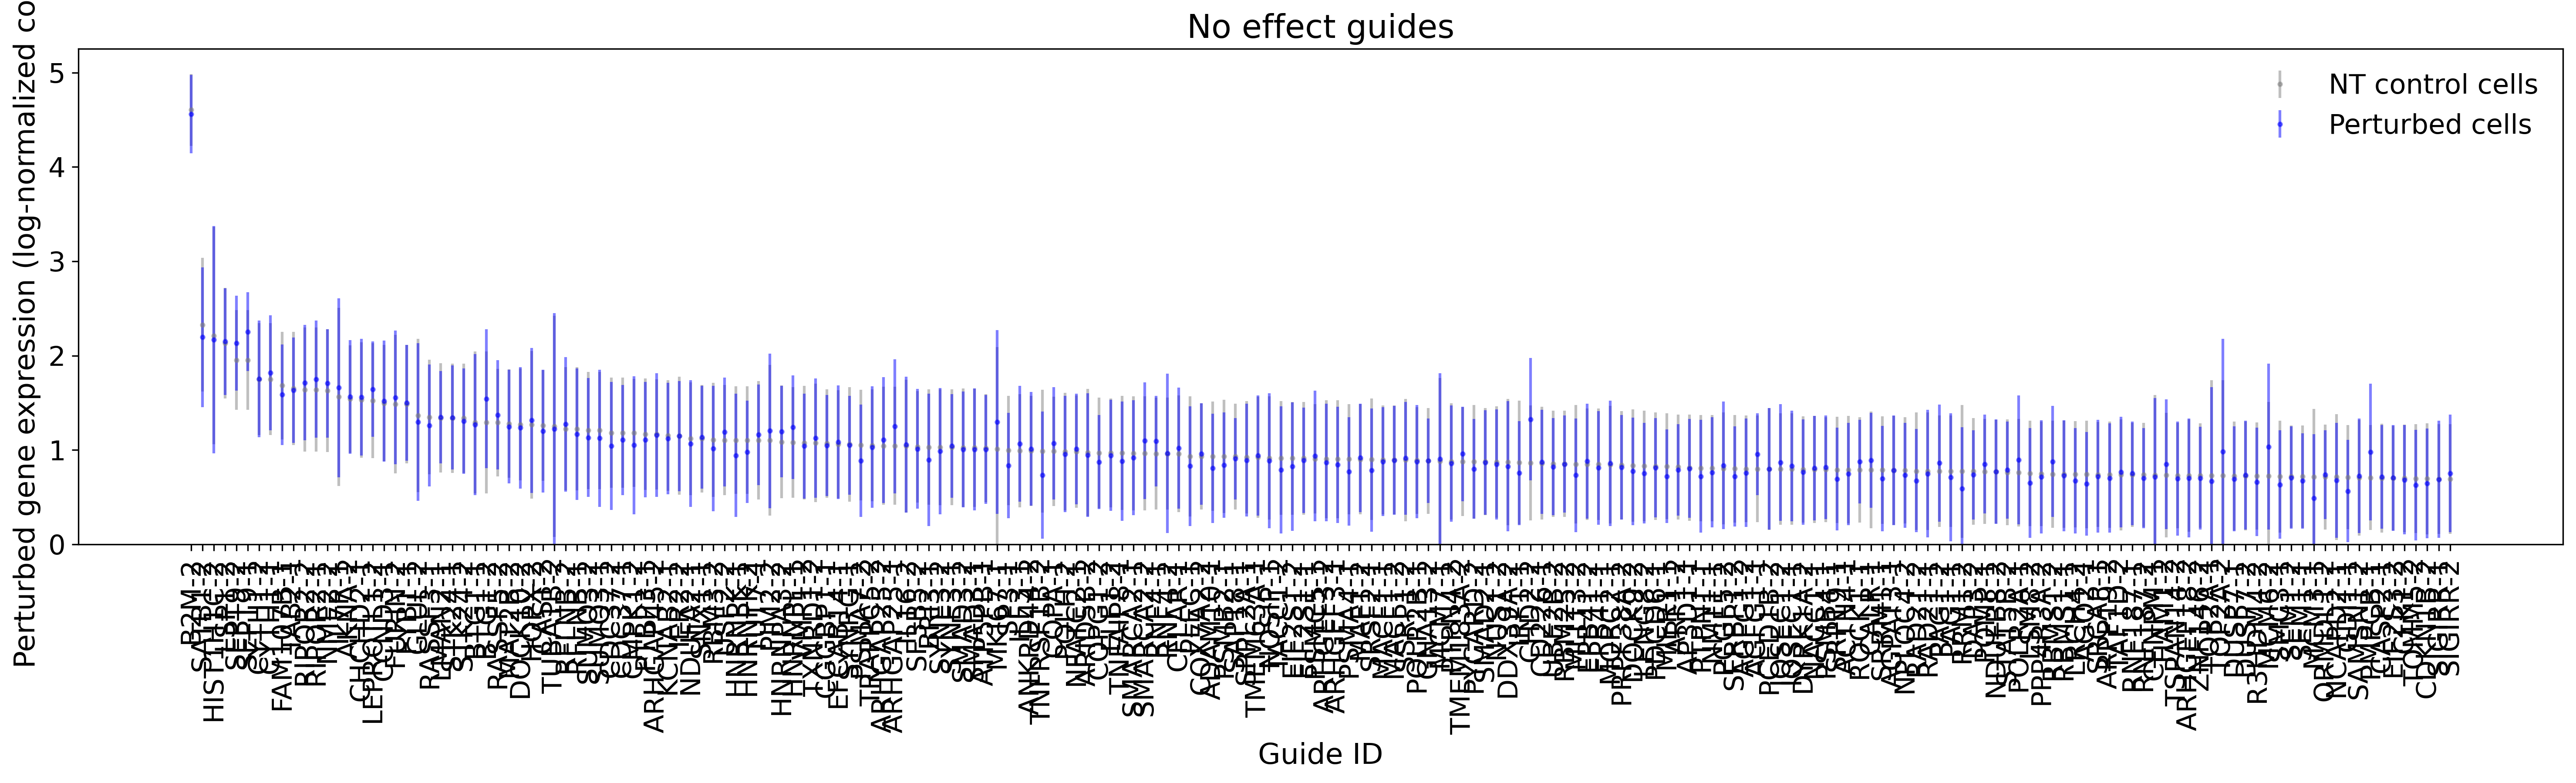

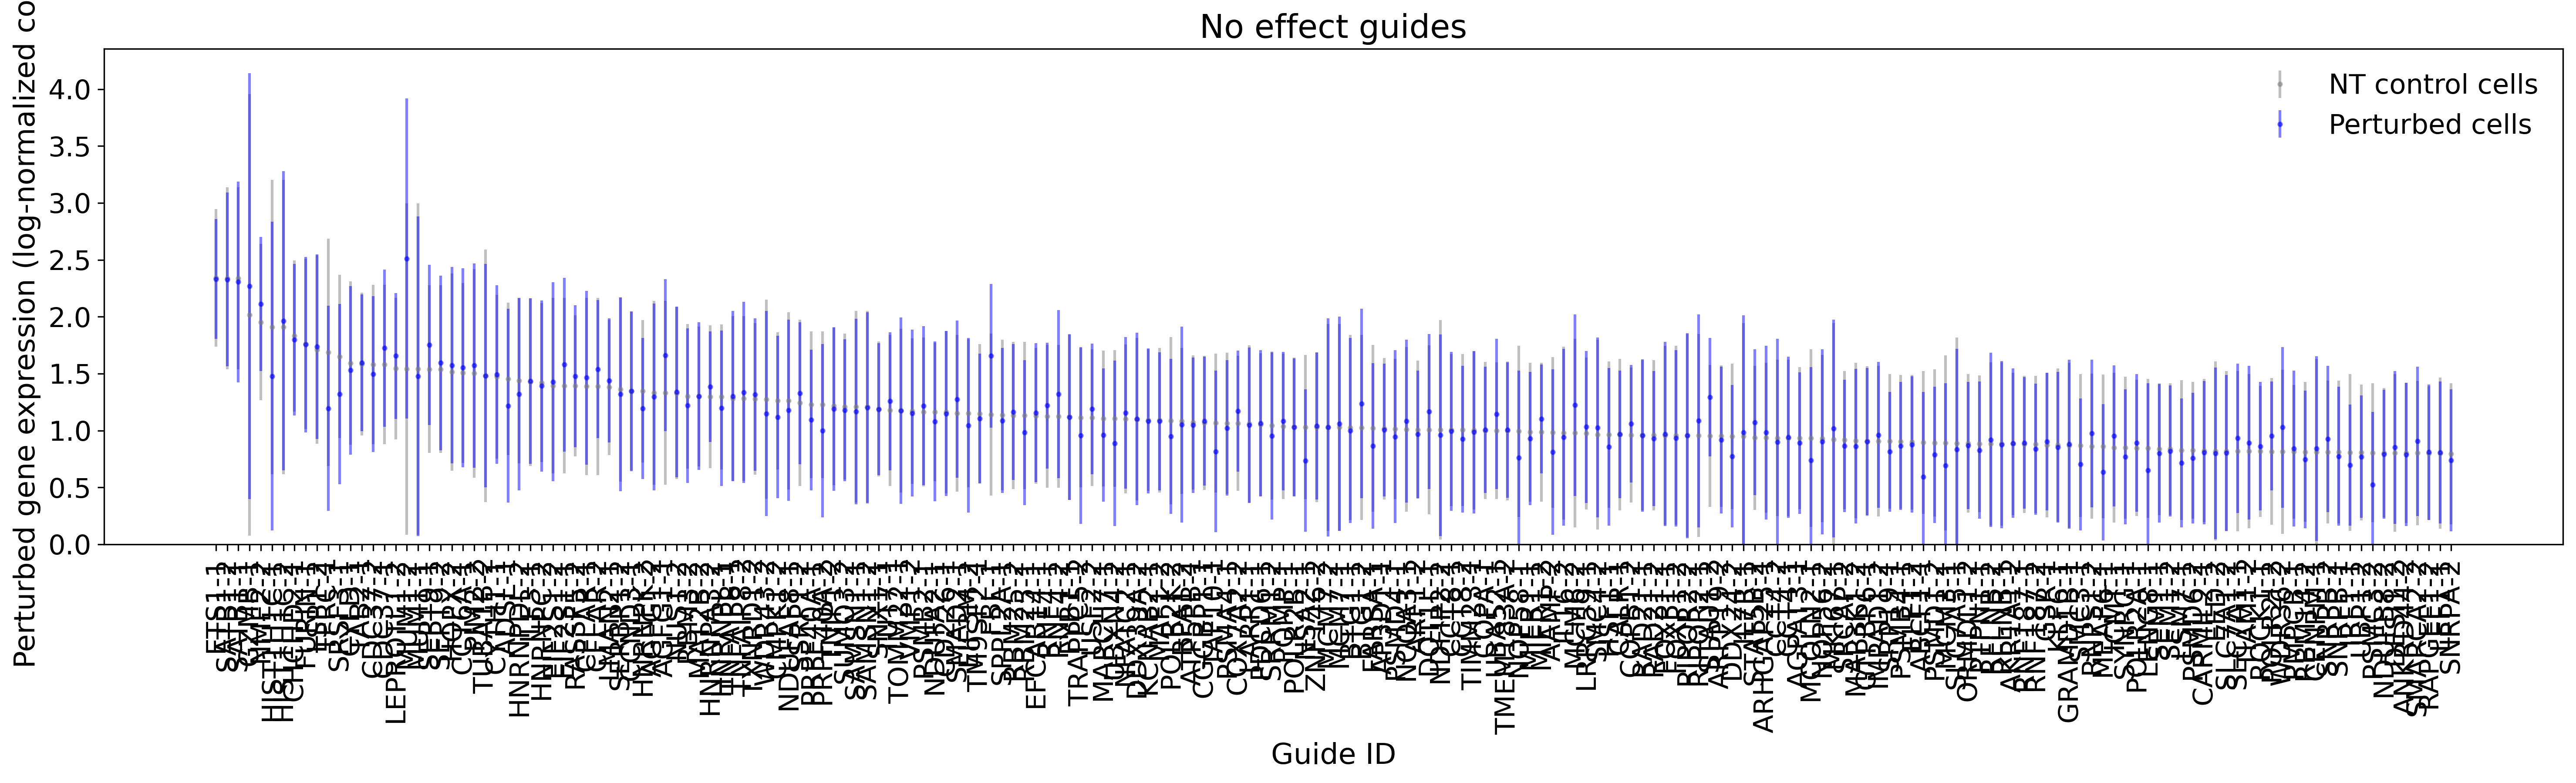

In [38]:
pl_df = rest_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[rest_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

pl_df = stim_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[stim_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

### Save list of putative ineffective guides (across conditions)

In [41]:
no_effect_guides = np.intersect1d(rest_ttest_df.index[rest_ttest_df['high_confidence_no_effect_guides']], stim_ttest_df.index[stim_ttest_df['high_confidence_no_effect_guides']])
no_effect_guides = np.intersect1d(no_effect_guides, stim48_ttest_df.index[stim48_ttest_df['high_confidence_no_effect_guides']])
no_effect_guides = no_effect_guides.tolist()
print(len(no_effect_guides))

1249


In [59]:
sgrna_library_metadata_clean.loc[no_effect_guides].columns

Index(['chromosome', 'pos', 'seq_last19bp', 'strand', 'PAM', 'note', 'flag',
       'seq', 'target_gene_name_from_sgRNA', 'designed_target_gene_id',
       'designed_target_gene_name', 'target_gene_id', 'target_gene_name',
       'distance_to_closest_target_tss', 'nearby_gene_within_2kb',
       'nearby_gene_within_30kb', 'nearest_within2kb_gene_id',
       'nearest_within2kb_gene_name', 'nearest_within2kb_gene_dist',
       'nearest_within2kb_nontarget_gene_id',
       'nearest_within2kb_nontarget_gene_name',
       'nearest_within2kb_nontarget_gene_dist',
       'putative_bidirectional_promoter', 'other_alignment_chromosome',
       'other_alignment_pos'],
      dtype='object')

In [83]:
stim_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)

guide_id  guide_mean_expr  guide_std_expr  guide_n  ntc_mean_expr  \
0          A1BG-2         0.000000        0.000000    726.0       0.000000   
1           A2M-2         0.000000        0.000000    497.0       0.000011   
2          AAAS-1         0.279501        0.403362   1274.0       0.347733   
3          AAAS-2         0.024415        0.160103     43.0       0.347733   
4          AACS-1         0.007226        0.066509    835.0       0.185269   
...           ...              ...             ...      ...            ...   
24851  SLC25A35-1         0.000000      100.000000      1.0       0.058818   
24852    SNRPD1-1         0.639537      100.000000      1.0       0.109661   
24853      ILF2-1         0.000000      100.000000      1.0       1.117618   
24854      UFD1-2         0.348253      100.000000      1.0       0.500549   
24855    CHMP2A-1         1.063486      100.000000      1.0       0.814868   

       ntc_std_expr     ntc_n  t_statistic       p_value   adj_p_value  \
0          0.000000  617446.0          NaN           NaN           NaN   
1          0.003206  617446.0    -2.590546  9.582612e-03  1.136137e-02   
2          0.452147  617446.0    -6.029937  2.142971e-09  2.908877e-09   
3          0.452147  617446.0   -13.238615  1.364571e-16  1.990099e-16   
4          0.363134  617446.0   -75.840827  0.000000e+00  1.000000e-16   
...             ...       ...          ...           ...           ...   
24851      0.205250  617446.0    -0.000588           NaN           NaN   
24852      0.276287  617446.0     0.005299           NaN           NaN   
24853      0.712940  617446.0    -0.011176           NaN           NaN   
24854      0.507448  617446.0    -0.001523           NaN           NaN   
24855      0.582122  617446.0     0.002486           NaN           NaN   

       signif_knockdown perturbed_gene_id     rank  \
0                 False   ENSG00000121410    317.0   
1                  True   ENSG00000175899    889.0   
2                  True   ENSG00000094914   8110.0   
3                  True   ENSG00000094914   8110.0   
4                  True   ENSG00000081760   5994.0   
...                 ...               ...      ...   
24851             False   ENSG00000125434   4025.0   
24852             False   ENSG00000167088   4916.0   
24853             False   ENSG00000143621  12209.0   
24854             False   ENSG00000070010   9596.0   
24855             False   ENSG00000130724  11426.0   

       high_confidence_no_effect_guides  
0                                 False  
1                                 False  
2                                 False  
3                                 False  
4                                 False  
...                                 ...  
24851                             False  
24852                             False  
24853                             False  
24854                             False  
24855                             False  

[24856 rows x 14 columns]

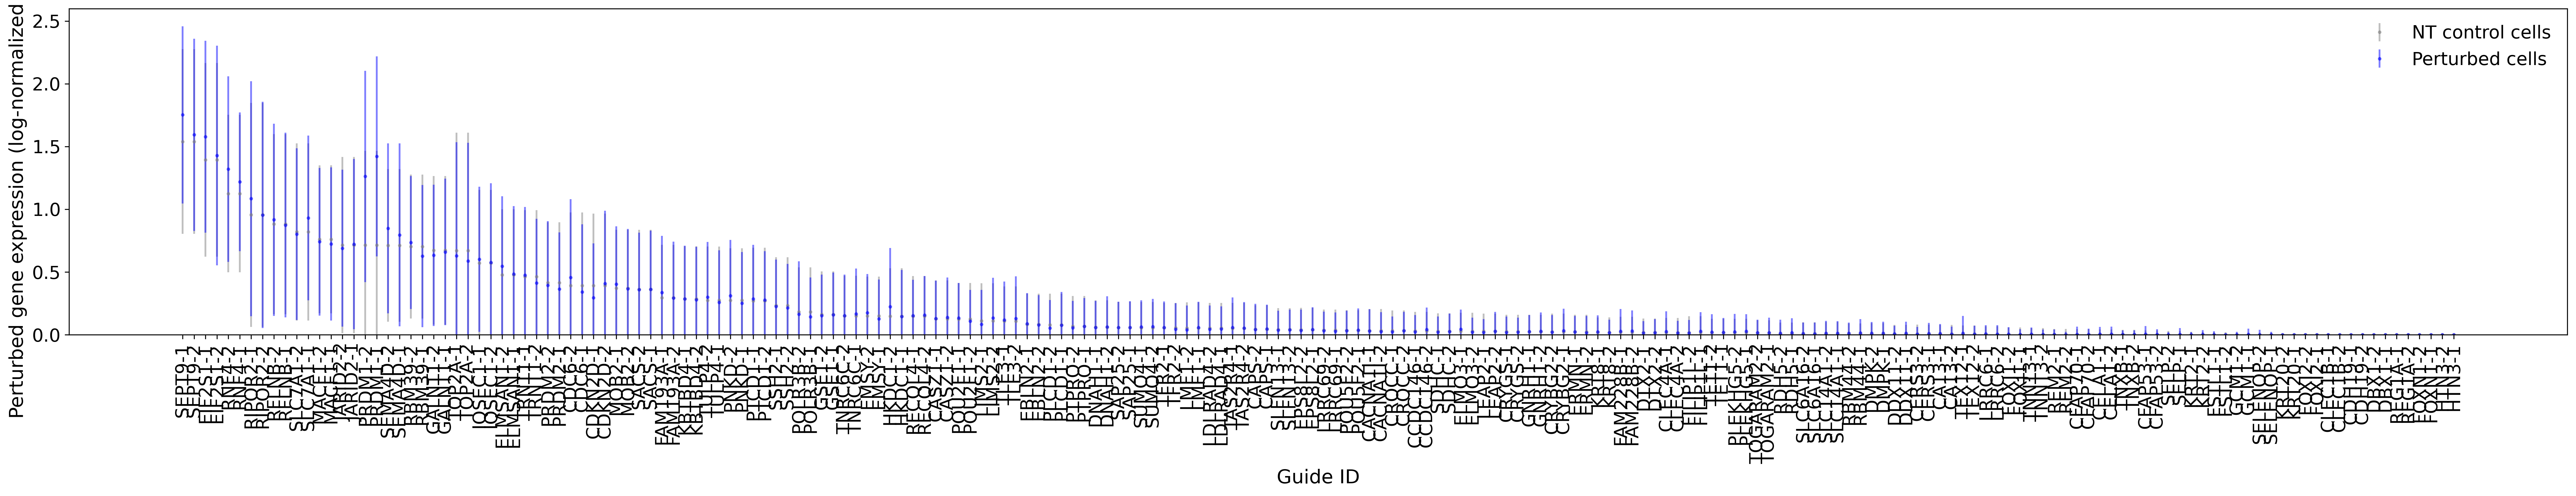

In [96]:
pl_guides = sgrna_library_metadata_clean.index[sgrna_library_metadata_clean.target_gene_name.isin(sgrna_library_metadata_clean.loc[no_effect_guides]['target_gene_name'].value_counts()[0:100].index.tolist())].tolist()
pl_df = stim_ttest_df.loc[pl_guides].reset_index().rename({'index':'guide_id'}, axis=1)
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(30,6))

In [99]:
# Save no_effect_guides to a text file
with open(os.path.join(results_dir, 'no_effect_guides.txt'), 'w') as f:
    for guide in no_effect_guides:
        f.write(f"{guide}\n")


In [100]:
len(no_effect_guides)

1249